# Product sale by region

Demand is different in each region. We want to choose the optimal price per region, but we don't know the demand.

[We follow this notebook as an example](https://bayesianbandits.readthedocs.io/en/latest/notebooks/delayed-reward.html)

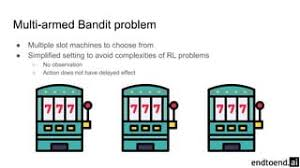



In [1]:
import numpy as np

np.random.seed(2)

class GeographicPricing:
    def __init__(self, num_locations: int):
        # Randomly generate demand parameters for each location
        self.demand_intercepts = np.random.uniform(low=50, high=100, size=num_locations)
        self.demand_slopes = np.random.uniform(low=-2, high=-0.1, size=num_locations)

        self.num_locations = num_locations

    def demand(self, location: int, price: int) -> float:
        # Linear demand function
        return max(
            self.demand_intercepts[location] + self.demand_slopes[location] * price, 0
        )

    def margin(self, location: int, price: int) -> float:
        # Margin is price times demand, as we're assuming zero marginal cost
        return price * self.demand(location, price)

    def adjust_demand(self):
        # Randomly adjust demand parameters for all locations
        adjustment_factor_intercept = np.random.uniform(
            low=-0.1, high=0.1, size=self.num_locations
        )
        adjustment_factor_slope = np.random.uniform(
            low=-0.05, high=0.05, size=self.num_locations
        )
        self.demand_intercepts += adjustment_factor_intercept * self.demand_intercepts
        self.demand_slopes += adjustment_factor_slope * self.demand_slopes

    def reset_demand(self):
        # Reset demand parameters to original values
        self.demand_intercepts = np.random.uniform(
            low=50, high=100, size=self.num_locations
        )
        self.demand_slopes = np.random.uniform(
            low=-2, high=-0.1, size=self.num_locations
        )


oracle = GeographicPricing(10)

In [7]:
oracle.demand(4, 3), oracle.margin(4, 3)

(66.06969733856187, 198.2090920156856)

### Action space

In [9]:
from enum import Enum


class Price(Enum):
    price_5 = 5
    price_8 = 8
    price_11 = 11
    price_14 = 14
    price_17 = 17

    #Esta es la función de reward / recompensa
    def take_action(self, location: int) -> float:
        return oracle.margin(location, self.value)

In [10]:
from bayesianbandits import NormalInverseGammaRegressor, Arm, ContextualAgent, ThompsonSampling

est = NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10))
policy = ThompsonSampling()

#Arms son acciones!
arms = [
    Arm(
        Price.price_5,
        learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
    ),
    Arm(
        Price.price_8,
        learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
    ),
    Arm(
        Price.price_11,
        learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
    ),
    Arm(
        Price.price_14,
        learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
    ),
    Arm(
        Price.price_17,
        learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
    ),
]

agent = ContextualAgent(arms=arms, policy=policy, random_seed=111)

In [11]:
agent

ContextualAgent(policy=ThompsonSampling(), random_seed=Generator(PCG64),
arms={<Price.price_8: 8>, <Price.price_11: 11>, <Price.price_5: 5>, <Price.price_17: 17>, <Price.price_14: 14>}, reward_function={<function identity at 0x1072d3a60>},
learners={<class 'bayesianbandits._estimators.NormalInverseGammaRegressor'>})

## Por ciudad, tomamos una decisión (precio) por día

In [31]:
one_hot_encoding = np.append(np.ones((10, 1)), np.eye(10), axis=-1)

regret: list[float] = []

best_price_per_city = np.array(
    [
        [oracle.margin(location, price.value) for price in Price]
        for location in range(10)
    ]
).max(axis=1)

number_of_days = 365

for iteration in range(number_of_days):
    # Pick prices for each location
    decisions = agent.pull(one_hot_encoding)
    if iteration == 2:
        decision_2 = decisions
    elif iteration == 364:
        final_decisions = decisions

    # End of the day, collect rewards
    rewards = [token.take_action(location) for location, token in enumerate(decisions)]
    #Regret es la diferencia (por periodo) entre el mejor reward posible y lo que decidí en el momento
    regret.append((best_price_per_city - np.array(rewards)).sum())

    # Update the agent
    for token, reward, context_row in zip(decisions, rewards, one_hot_encoding):
        agent.select_for_update(token).update(
            np.atleast_2d(context_row), np.atleast_1d(reward)
        )

In [28]:
decision_2

[<Price.price_14: 14>,
 <Price.price_14: 14>,
 <Price.price_17: 17>,
 <Price.price_14: 14>,
 <Price.price_14: 14>,
 <Price.price_14: 14>,
 <Price.price_14: 14>,
 <Price.price_14: 14>,
 <Price.price_14: 14>,
 <Price.price_14: 14>]

In [29]:
decisions

[<Price.price_17: 17>,
 <Price.price_17: 17>,
 <Price.price_17: 17>,
 <Price.price_17: 17>,
 <Price.price_17: 17>,
 <Price.price_17: 17>,
 <Price.price_17: 17>,
 <Price.price_17: 17>,
 <Price.price_17: 17>,
 <Price.price_17: 17>]

Text(0, 0.5, 'Cumulative Regret')

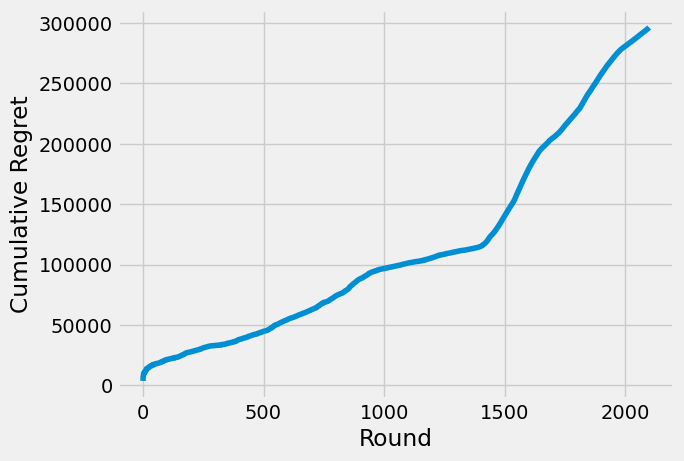

In [13]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

plt.plot(np.cumsum(regret))
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")

### Ahora ajustamos la demanda cada semana

Esto simula un ambiente que va cambiando en el tiempo

Text(0, 0.5, 'Cumulative Regret')

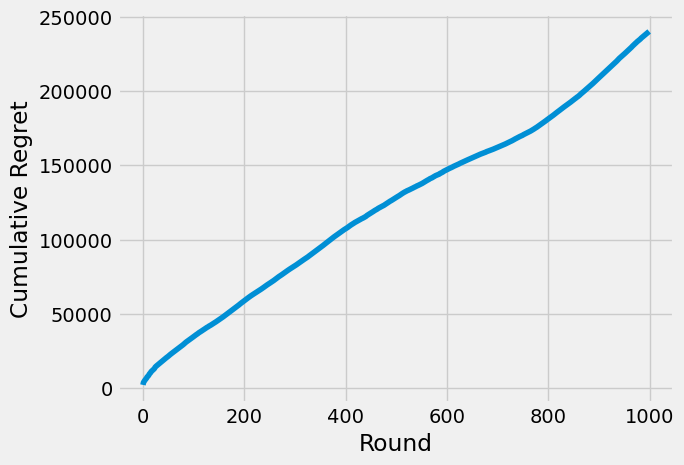

In [15]:
agent = ContextualAgent(
    arms=[
        Arm(
            Price.price_5,
            learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
        ),
        Arm(
            Price.price_8,
            learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
        ),
        Arm(
            Price.price_11,
            learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
        ),
        Arm(
            Price.price_14,
            learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
        ),
        Arm(
            Price.price_17,
            learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
        ),
    ],
    policy=policy,
    random_seed=111,
)
np.random.seed(2)
one_hot_encoding = np.append(np.ones((10, 1)), np.eye(10), axis=-1)

regret: list[float] = []

for iteration in range(1000):
    # Start of each week, randomly adjust demand
    if iteration % 7 == 0:
        oracle.adjust_demand()

    # Recompute best price per city
    best_price_per_city = np.array(
        [
            [oracle.margin(location, price.value) for price in Price]
            for location in range(10)
        ]
    ).max(axis=1)

    # Start of the day, adjust prices
    decisions = agent.pull(one_hot_encoding)

    # End of the day, collect rewards
    rewards = [token.take_action(location) for location, token in enumerate(decisions)]
    regret.append((best_price_per_city - np.array(rewards)).sum())

    # Update the agent
    for token, reward, context_row in zip(decisions, rewards, one_hot_encoding):
        agent.select_for_update(token).update(
            np.atleast_2d(context_row), np.atleast_1d(reward)
        )

plt.plot(np.cumsum(regret))
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")

>Now, we see that the agent’s performance is much worse. This is because the agent is not able to adapt to the changing demand. As we can see in the below plot, the agent begins to learn the true demand distribution, but then it changes, and the agent has already found a very narrow posterior distribution for the demand. Unfortunately, this posterior is out of date, so the agent will be slow to adapt.

>Instead, we can utilize the Agent.decay method to increase the variance of our posterior distributions, thereby encouraging the agent to maintain a baseline level of exploration. The choice of decay_rate is arbitrary, it is essentially an exponential decay rate that increases the variance of the posterior distributions. We can see that this helps the agent adapt to the changing demand. However, decaying too often can prevent the agent from ever learning how to maximize the reward.




/Users/cristiandagnino/miniforge3/envs/ds_stack/lib/python3.11/site-packages/bayesianbandits/_estimators.py:1003: LinAlgWarning: Ill-conditioned matrix (rcond=1.00763e-16): result may not be accurate.
  shape = solve(
/Users/cristiandagnino/miniforge3/envs/ds_stack/lib/python3.11/site-packages/bayesianbandits/_estimators.py:975: LinAlgWarning: Ill-conditioned matrix (rcond=1.06297e-16): result may not be accurate.
  m_n = solve(
/Users/cristiandagnino/miniforge3/envs/ds_stack/lib/python3.11/site-packages/bayesianbandits/_estimators.py:975: LinAlgWarning: Ill-conditioned matrix (rcond=1.08188e-16): result may not be accurate.
  m_n = solve(
/Users/cristiandagnino/miniforge3/envs/ds_stack/lib/python3.11/site-packages/bayesianbandits/_estimators.py:975: LinAlgWarning: Ill-conditioned matrix (rcond=1.07918e-16): result may not be accurate.
  m_n = solve(
/Users/cristiandagnino/miniforge3/envs/ds_stack/lib/python3.11/site-packages/bayesianbandits/_estimators.py:975: LinAlgWarning: Ill-condi

Text(0, 0.5, 'Cumulative Regret')

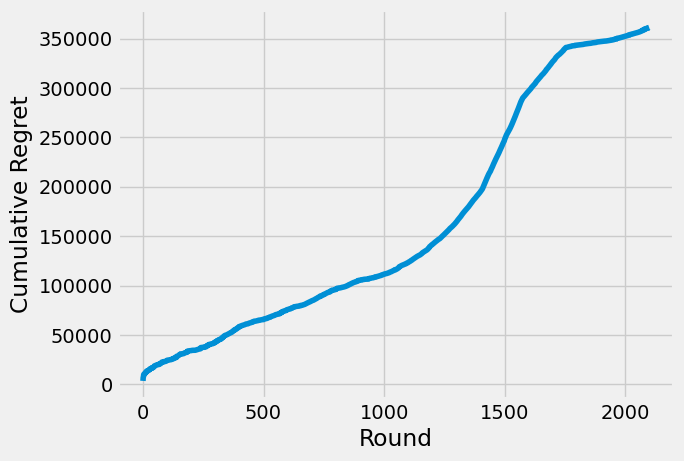

In [16]:
np.random.seed(2)
oracle.reset_demand()
agent = ContextualAgent(
    arms=[
        Arm(
            Price.price_5,
            learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
        ),
        Arm(
            Price.price_8,
            learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
        ),
        Arm(
            Price.price_11,
            learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
        ),
        Arm(
            Price.price_14,
            learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
        ),
        Arm(
            Price.price_17,
            learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
        ),
    ],
    policy=policy,
    random_seed=111,
)


regret: list[float] = []

for iteration in range(2100):
    # Start of each week, randomly adjust demand
    if iteration % 7 == 0:
        oracle.adjust_demand()

    # Recompute best price per city
    best_price_per_city = np.array(
        [
            [oracle.margin(location, price.value) for price in Price]
            for location in range(10)
        ]
    ).max(axis=1)

    # Start of the day, adjust prices
    decisions = agent.pull(one_hot_encoding)

    # End of the day, collect rewards
    rewards = [token.take_action(location) for location, token in enumerate(decisions)]
    regret.append((best_price_per_city - np.array(rewards)).sum())

    # Update the agent
    for token, reward, context_row in zip(decisions, rewards, one_hot_encoding):
        agent.select_for_update(token).update(
            np.atleast_2d(context_row), np.atleast_1d(reward)
        )

    # End of each month, decay the bandit
    agent.decay(one_hot_encoding[0], decay_rate=0.985) #0.98

plt.plot(np.cumsum(regret))
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")